In [11]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *

%matplotlib inline
np.random.seed(1)

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [12]:
from Preprocess_image import take_n_resize_images as take

In [17]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 2


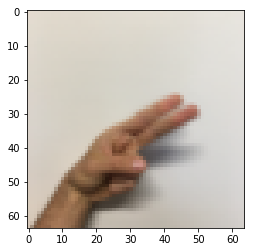

In [18]:
# Example of a picture
index = 2
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [19]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [23]:
# GRADED FUNCTION: create_placeholders

def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    X = tf.placeholder(shape=[None,n_H0,n_W0,n_C0],dtype=tf.float32)
    Y = tf.placeholder(shape=[None,n_y],dtype=tf.float32)
    
    return X, Y

In [24]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 3, 8]
                        W2 : [2, 2, 8, 16]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    tf.set_random_seed(1)

    W1 = tf.get_variable("W1",[4,4,3,8],initializer=tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2",[2,2,8,16],initializer=tf.contrib.layers.xavier_initializer(seed = 0))

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [25]:
# GRADED FUNCTION: forward_propagation

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']

    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X,W1,strides=[1, 1 ,1 ,1],padding='SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1,ksize=[1,8,8,1],strides=[1,8,8,1],padding='SAME')
    
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1,W2,strides=[1,1,1,1],padding='SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2,ksize=[1,4,4,1],strides=[1,4,4,1],padding='SAME')
    
    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function
    # 6 neurons in output layer.
    Z3 = tf.contrib.layers.fully_connected(P2,6, activation_fn=None)
    return Z3

In [26]:
# GRADED FUNCTION: compute_cost 

def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """

    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y) )
    
    return cost
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    

In [27]:
# GRADED FUNCTION: model

def train_model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True, 
                name_model = "models/SignModel.ckpt", save = False, 
                load_model = False, load_model_path = None):

    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(13)                             # to keep results consistent (tensorflow seed)
    seed = 13                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost =  compute_cost(Z3, Y)

    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
    
    if (save or load_model): saver = tf.train.Saver()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        

        # Run the initialization
        if (load_model == False): sess.run(init)
        else: saver.restore(sess, load_model_path)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch

                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        if (save): saved_path = saver.save(sess, name_model)
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
        
                
        return train_accuracy, test_accuracy, saved_path, parameters

In [28]:
# GRADED FUNCTION: model

def test_model(X_test, Y_test, model_name, saved_path):
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(13)                             # to keep results consistent (tensorflow seed)
    seed = 13                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_test.shape             
    n_y = Y_test.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)


    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)

    saver = tf.train.Saver()
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:

        saver.restore(sess, saved_path)

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("\nTest Accuracy:", test_accuracy)
        
                
        return test_accuracy

In [29]:
# GRADED FUNCTION: model

def predict(X_test, num_classes, saved_path):
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(13)                             # to keep results consistent (tensorflow seed)
    seed = 13                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_test.shape             
    n_y = num_classes                           
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)


    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Y = forward_propagation(X, parameters)

    saver = tf.train.Saver()
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:

        saver.restore(sess, saved_path)
        
        classification = sess.run(tf.argmax(Y,1), {X: X_test})
                
        return classification

Cost after epoch 0: 1.913768
Cost after epoch 5: 1.619776
Cost after epoch 10: 0.981428
Cost after epoch 15: 0.768697
Cost after epoch 20: 0.568112
Cost after epoch 25: 0.509013
Cost after epoch 30: 0.470194
Cost after epoch 35: 0.390161
Cost after epoch 40: 0.359361
Cost after epoch 45: 0.356056
Cost after epoch 50: 0.314368
Cost after epoch 55: 0.359223
Cost after epoch 60: 0.267073
Cost after epoch 65: 0.248274
Cost after epoch 70: 0.228651
Cost after epoch 75: 0.258161
Cost after epoch 80: 0.172087
Cost after epoch 85: 0.178208
Cost after epoch 90: 0.263720
Cost after epoch 95: 0.186613


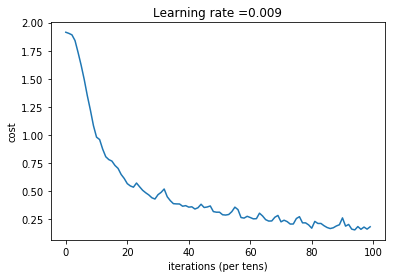

Train Accuracy: 0.9425926
Test Accuracy: 0.85


In [49]:
_, _, saved_path, parameters = train_model(X_train, 
                                           Y_train, 
                                           X_test, 
                                           Y_test, 
                                           num_epochs = 100, 
                                           name_model = "models/SignModel_f.ckpt", 
                                           save = True)

In [30]:
_ = test_model(X_test, Y_test, "models/SignModel_f.ckpt.meta", "models/SignModel_f.ckpt")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from models/SignModel_f.ckpt

Test Accuracy: 0.85


In [90]:
new_X = take("datasets/images",
             num_examples = 1,
             image_size = (64,64),
             start = 10,
             resize = False)

In [70]:
import Database as d

In [77]:
NAME_DATABASE = "Signs.db"
NAME_TABLE = "Images"
FIELD = "Data"
FILENAME = "datasets/images/sign(1006).jpg"
SAVE_PATH = "datasets/test_sign.jpg"

In [78]:
d.Create_table(NAME_DATABASE, NAME_TABLE, FIELD)
d.Add_values(NAME_DATABASE, NAME_TABLE, FIELD, FILENAME)
binary_img = d.Get_values(NAME_DATABASE, NAME_TABLE, FIELD)

Success
Success
Success


In [79]:
d.WriteImage(binary_img, SAVE_PATH)

In [80]:
new_X.shape

(1, 64, 64, 3)

In [81]:
new_Y = convert_to_one_hot(np.array(np.random.randint(6,size = new_X.shape[0])), 6).T
#new_Y = convert_to_one_hot(np.array([5,2,5,0,5,3,1,2,2,3,3,0,2,2,2]), 6).T

In [82]:
new_Y.shape

(1, 6)

In [91]:
answers = [np.squeeze(answer) for answer in predict(new_X, 6, "models/SignModel_f.ckpt")]

INFO:tensorflow:Restoring parameters from models/SignModel_f.ckpt


In [92]:
answers

[4]

y =  4


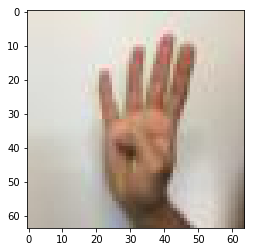

In [93]:
for i in range(len(new_X)):
    print("y = ", answers[i])
    plt.imshow(new_X[i])
    plt.show()